# Setup

In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

## <font color='orange'>Parameters</font> 

In [2]:
# these are for grouping into the IOD years since the effects are 
# not confined to a single year. You chose this to have an even 
# number of months around the IOD peak..but now you left it in
# line with the SLA plots that start in 06 and end in 05
IODyear_begin = '-06-01' # month-day of IOD year
IODyear_end = '-05-31' # month-day of year AFTER IOD year

## <font color='orange'>Functions</font> 

In [3]:
def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

def IOD_year_group(invar,begin,end,IODyears):
    data= []
    for ii,year in enumerate(IODyears):
        start_time = str(year) + begin
        end_time = str(year+1) + end
        time_slice = slice(start_time, end_time)
#         print(time_slice)
        data.append(invar.sel(time=time_slice))
        
    # add all the data together
    data = xr.concat(data, dim='time')
    # take the mean for each month of all the years
    data = data.groupby('time.month').mean(dim='time')
    #start in June instead of 01
    data = data.roll(month=-5,roll_coords = False)
        
    return data

def plot_annual_cycle(invar,cmap,cmin,cmax,clabel,levels,stitle):
    
    fig = plt.figure(figsize=(20, 20))
    plt.rcParams.update({'font.size': 20})
    
    months = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']

    for mm in range(invar.shape[0]):
        ax = fig.add_subplot(4,3,mm+1, projection=ccrs.PlateCarree())
        cf = ax.contourf(lon,lat,invar[mm,:,:],levels = levels,cmap=cmap, extend="both")
        add_land(ax,[40,100,-5,30])
        plt.title(months[mm])
        
        if (mm == 0) | (mm == 3) | (mm == 6) | (mm == 9):
            plt.ylabel('Latitude')
            
        if (mm == 9) | (mm == 10) | (mm == 11):
            plt.xlabel('Longitude')
    
    plt.suptitle(stitle)
    cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
    cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
    cbar.set_label(clabel)
    
def plot_coastal_hovmueller(IODphases,cmap,cmin,cmax,clabel):
    # create list of integer years
    titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
    plt.rcParams.update({'font.size': 20})

    fig = plt.figure(figsize=(30, 10))
    for ii,phase in enumerate(IODphases):

        # Get times and make array of datetime objects
        vtimes = phase.month

        data = np.zeros([vtimes.shape[0],ds_CL.sta_loninds.shape[0]])*np.nan
    #     print(data.shape)
        for jj in range(ds_CL.sta_loninds.shape[0]):
            data[:,jj] = phase[:,ds_CL.sta_latinds[jj],ds_CL.sta_loninds[jj]]

        # colorbar limits
        levels = np.linspace(cmin, cmax, 8)

        # Specify longitude values for chosen domain
        sta = np.arange(len(ds_CL.sta_loninds))

        ax = fig.add_subplot(1,4,ii+1)

        # Plot of chosen variable averaged over latitude and slightly smoothed
        cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=cmap, extend="both")
        for loc in ds_CL.loc_list:
            plt.axvline(x=loc,color = 'k',linestyle = ':')

        plt.xlabel('Station')
        if ii == 0:
            plt.ylabel('Month')

        plt.title(titles[ii])
        ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
        ax.set_xticks(ds_CL.loc_list)
        ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
        ax.set_yticks(list(np.arange(1,13)))
        cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

    cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
    cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
    cbar.set_label(clabel)

## <font color='orange'>Read Data</font> 

In [17]:
# get data from tigress
path = '../data/CHL/'
# infn = 'all_L3m_AV_CHL1_100km_global_monthly_merged_1997_2020_processed.nc'
infn = 'chl_25km_processed.nc'
ds_CHL = xr.open_dataset(path + infn)
# ds_CHL

# Subset ------------------------------------------------#
# Create slice variables to subset domain before finding means
# lat_slice = slice(-20, 30) # bounds inclusive
# lon_slice = slice(40, 100) # bounds inclusive

# Get data, selecting lat/lon slice
# mon_chla = ds_CHL['mon_chla'].sel(lat=lat_slice,lon=lon_slice)
# mon_chla_mon_anom = ds_CHL['mon_chla_mon_anom'].sel(lat=lat_slice,lon=lon_slice)
# chla_mon_clim = ds_CHL['chla_mon_clim'].sel(lat=lat_slice,lon=lon_slice)
# lat = mon_chla_mon_anom.lat.values
# lon = mon_chla_mon_anom.lon.values

mon_chla = ds_CHL['mon_chla']
mon_chla_mon_anom = ds_CHL['mon_chla_mon_anom']
chla_mon_clim = ds_CHL['chla_mon_clim']
lat = mon_chla_mon_anom.lat.values
lon = mon_chla_mon_anom.lon.values

# load coastlines
ds_CL= xr.open_dataset('../data/SLA/SLA-coastlines-25km.nc')

In [18]:
ds_CHL.lon[ds_CL.sta_loninds][1:100]

<xarray.DataArray 'lon' (no_stations: 99)>
array([58.375, 58.625, 58.875, 59.125, 59.375, 59.625, 59.875, 60.125, 60.375,
       60.625, 60.875, 61.125, 61.375, 61.625, 61.875, 62.125, 62.375, 62.625,
       62.875, 63.125, 63.375, 63.625, 63.875, 64.125, 64.375, 64.625, 64.875,
       65.125, 65.375, 65.625, 65.875, 66.125, 66.375, 66.625, 66.875, 67.125,
       67.375, 67.625, 67.875, 68.125, 68.375, 68.625, 68.875, 69.125, 69.375,
       69.625, 69.875, 70.125, 70.375, 70.625, 70.875, 71.125, 71.375, 71.625,
       71.875, 72.125, 72.375, 72.625, 72.875, 73.125, 73.375, 73.625, 73.875,
       74.125, 74.375, 74.625, 74.875, 75.125, 75.375, 75.625, 75.875, 76.125,
       76.375, 76.625, 76.875, 77.125, 77.375, 77.625, 77.875, 78.125, 78.375,
       78.625, 78.875, 79.125, 79.375, 79.625, 79.875, 80.125, 80.375, 80.625,
       80.875, 81.125, 81.375, 81.625, 81.875, 82.125, 82.375, 82.625, 82.875])
Coordinates:
    lon          (no_stations) float64 58.38 58.62 58.88 ... 82.38 82.62 8

In [19]:
lon.shape

(340,)

## <font color='orange'>Group Into IOD Phases</font> 

In [20]:
# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

posIODyears = list(np.array(ds_DMI.pos_IOD_years[ds_DMI.pos_IOD_years >= 1994]))
# posIODyears = [1997,2019]
negIODyears = list(np.array(ds_DMI.neg_IOD_years[ds_DMI.neg_IOD_years >= 1994]))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years[ds_DMI.neu_IOD_years >= 1994]))

In [21]:
var = mon_chla_mon_anom
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIOD_mon_chla_mon_anom = IOD_year_group(var,IODyear_begin,IODyear_end,posIODyears)

# average over the positive IOD years -------------------------------------------# 
negIOD_mon_chla_mon_anom = IOD_year_group(var,IODyear_begin,IODyear_end,negIODyears)

# average over the positive IOD years -------------------------------------------# 
neuIOD_mon_chla_mon_anom = IOD_year_group(var,IODyear_begin,IODyear_end,neuIODyears)

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [22]:
IODphases[1].shape

(12, 200, 240)

# Hovmueller Diagrams

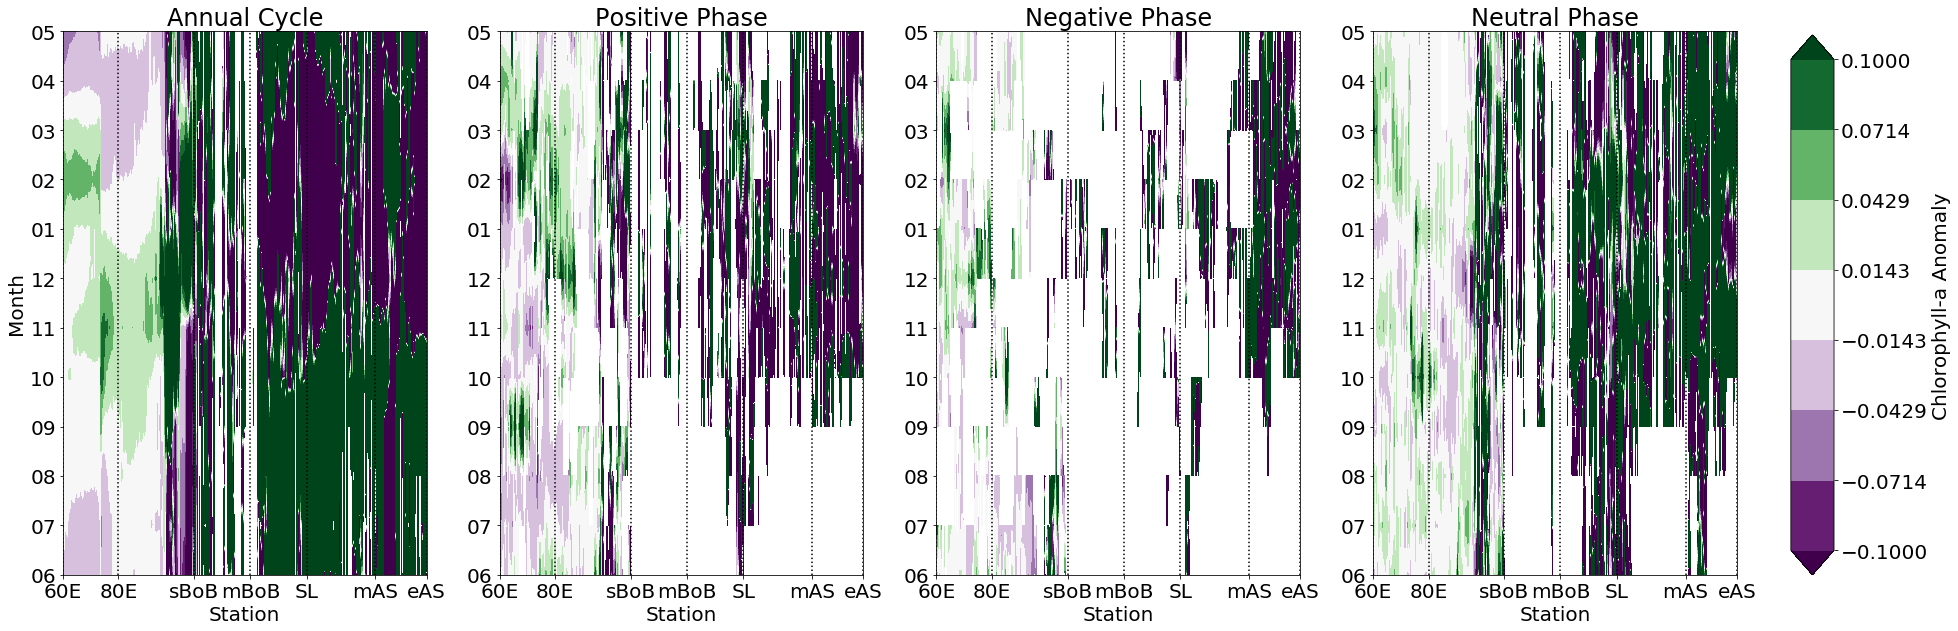

In [23]:
rolled_ann_cyc = chla_mon_clim.roll(month=-5,roll_coords = False)
IODphases = list([rolled_ann_cyc,posIOD_mon_chla_mon_anom,negIOD_mon_chla_mon_anom,neuIOD_mon_chla_mon_anom])
plot_coastal_hovmueller(IODphases,cmap=plt.cm.PRGn,cmin = -0.1,cmax=0.1,clabel = 'Chlorophyll-a Anomaly')

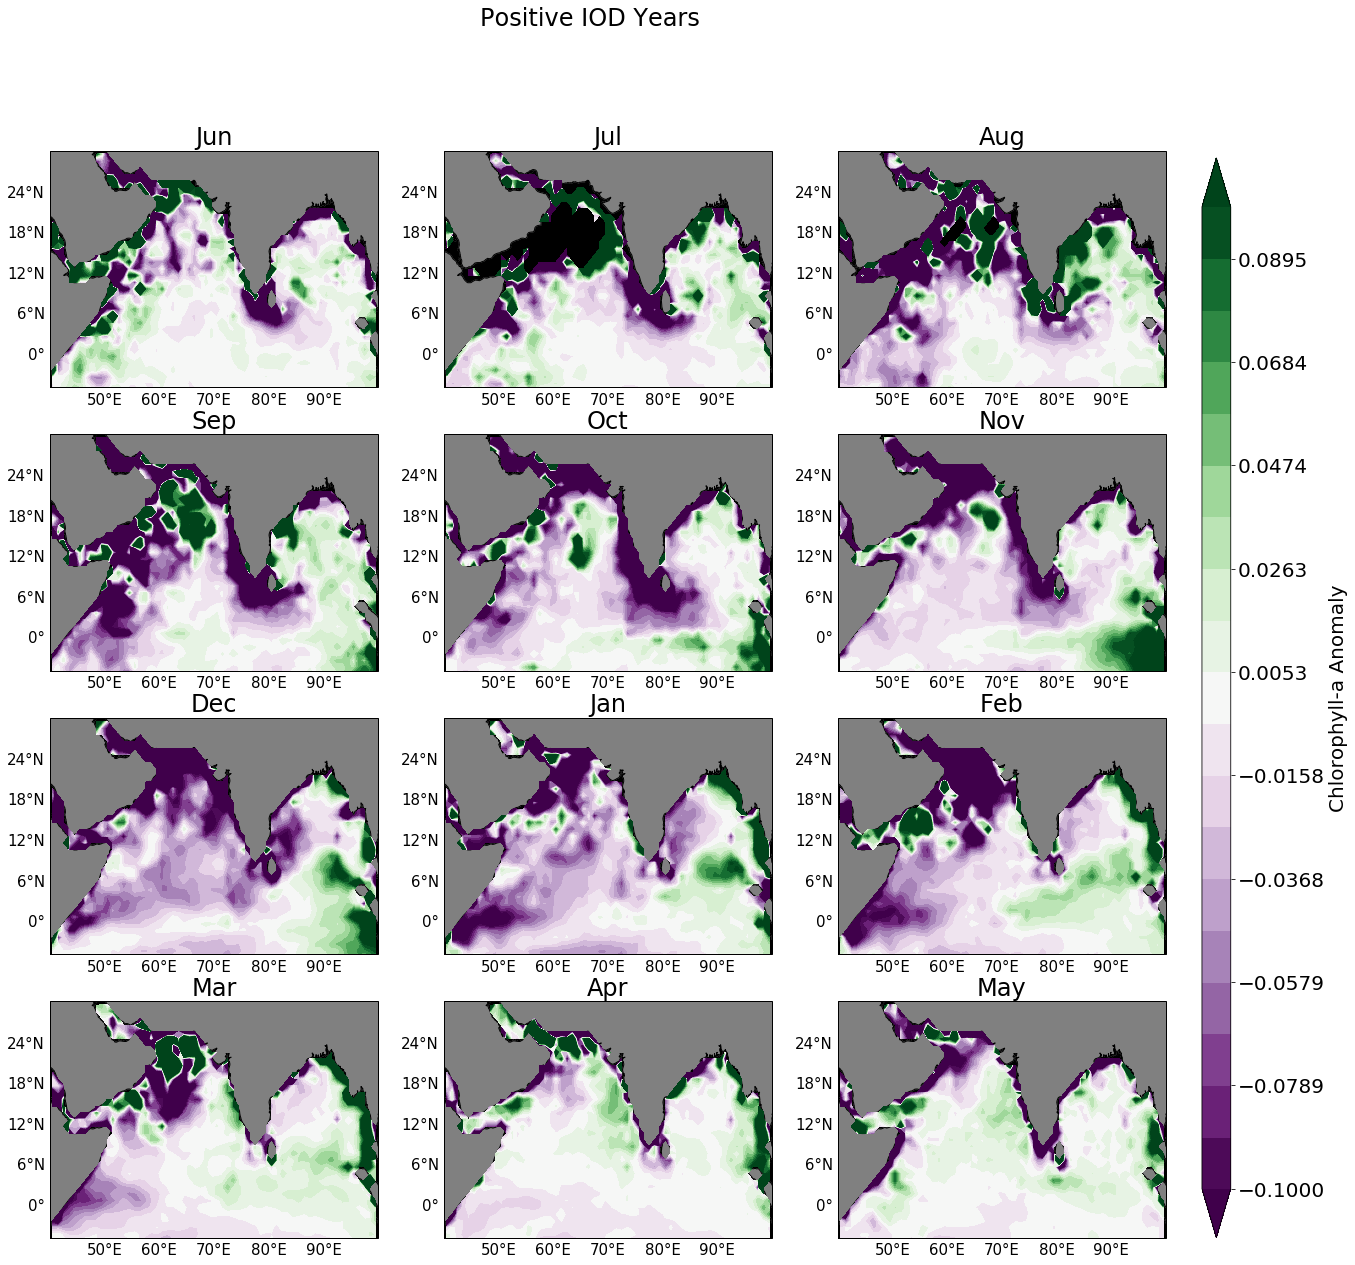

In [30]:
cmin = -0.1
cmax = 0.1

plot_annual_cycle(posIOD_mon_chla_mon_anom,cmap = plt.cm.PRGn,cmin=cmin,cmax=cmax,clabel = 'Chlorophyll-a Anomaly',
                  levels = np.linspace(cmin,cmax, 20),stitle ='Positive IOD Years')

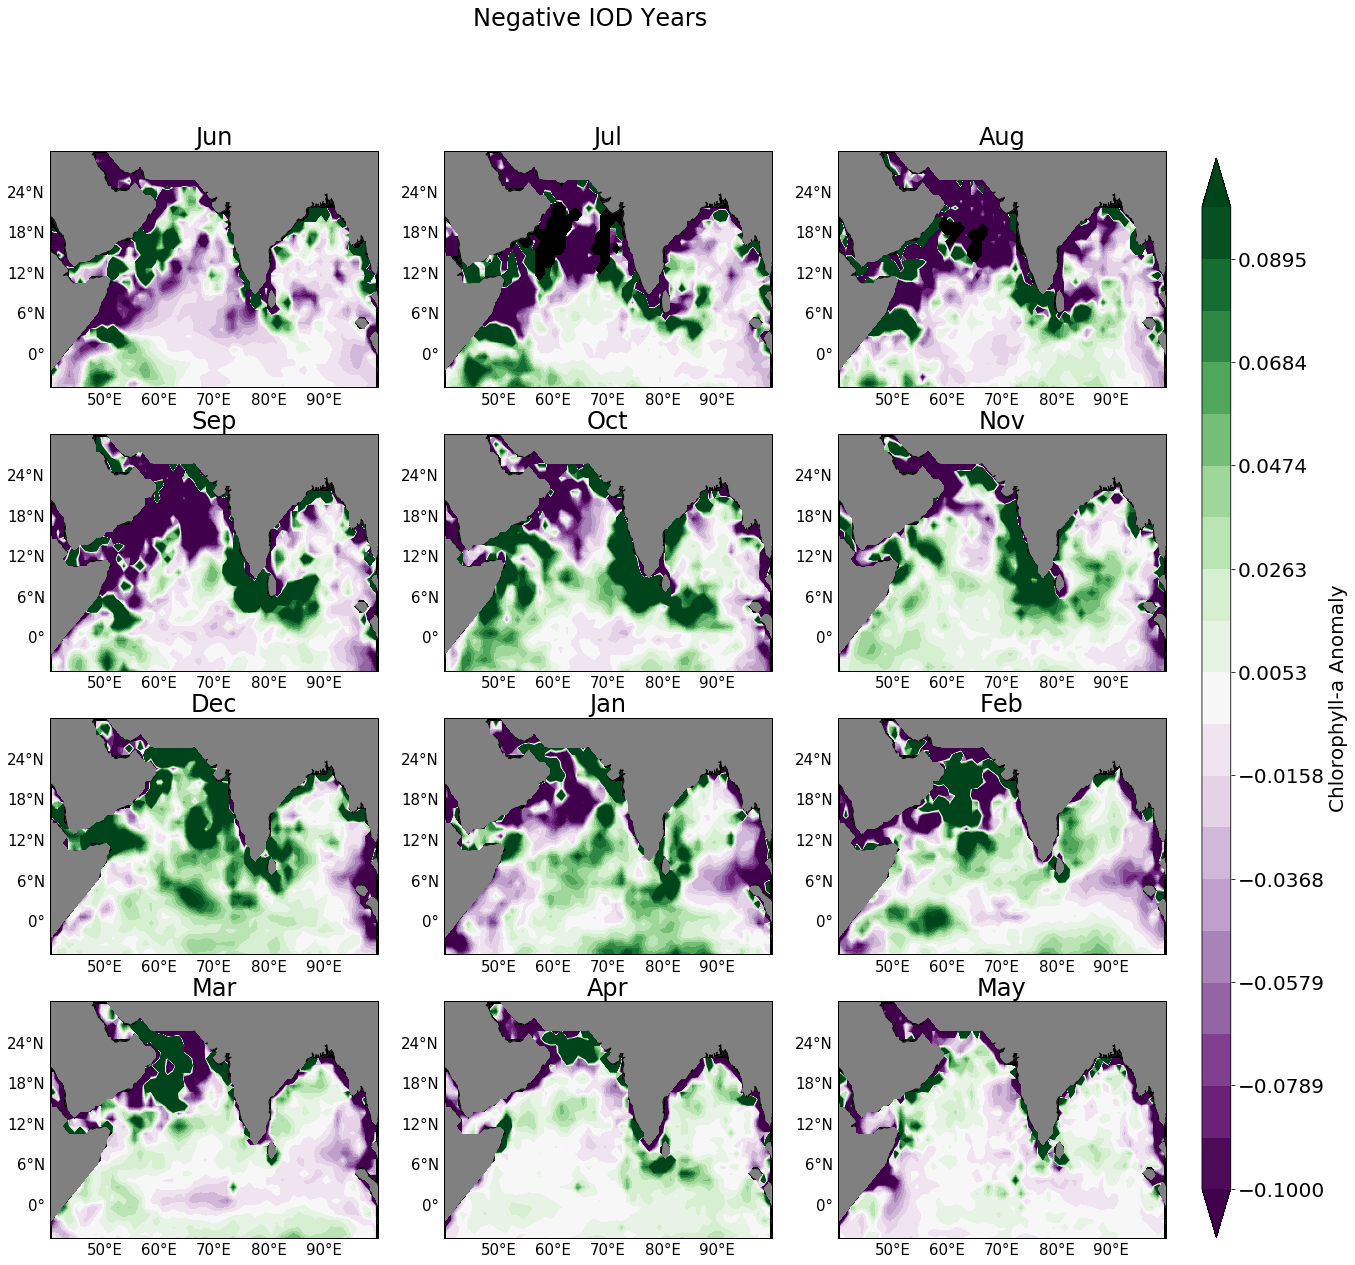

In [33]:
cmin = -0.1
cmax = 0.1

plot_annual_cycle(negIOD_mon_chla_mon_anom,cmap = plt.cm.PRGn,cmin=cmin,cmax=cmax,clabel = 'Chlorophyll-a Anomaly',
                  levels = np.linspace(cmin, cmax, 20),stitle ='Negative IOD Years')

In [43]:
cmin = -0.1
cmax = 0.1
plot_annual_cycle(neuIOD_mon_chla_mon_anom,cmap = plt.cm.RdBlu,cmin=cmin,cmax=cmax,clabel = 'Chlorophyll-a Anomaly',
                  levels = np.linspace(cmin, cmax, 20),stitle ='Neutral IOD Years')

AttributeError: module 'matplotlib.cm' has no attribute 'RdBlu'